In [ ]:
!pip install pycm

     |████████████████████████████████| 71kB 4.2MB/s 
     |████████████████████████████████| 573kB 7.7MB/s 


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.2MB 6.4MB/s 
     |████████████████████████████████| 870kB 24.8MB/s 
     |████████████████████████████████| 3.3MB 35.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=7d03a954efe356a0428f4a76735a3e808575994285c30c839cd5a292e7838924
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
#Importing all the necessary libraries
from pycm import *
from transformers import BertTokenizer, BertModel
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import pickle
import sys
from glob import glob  
import math
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataset
import torch.utils.data.dataloader
import torchvision.transforms as visionTransforms
import PIL.Image as Image
from torchvision.transforms import ToTensor,ToPILImage

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df=pd.read_csv("path_to_add/MIDAS_Task3/Datasets/Task3_Cleaned_TextModality.csv",index_col=0)  #Please add path_to_add that is required for your local Machine

In [ ]:
#Creating the train(0.8) test(0.1) and validation(0.1) splits
dfTrain,dfVal,dfTest=np.split(df.sample(frac=1, random_state=42), [int(.8 * len(df)), int(.9 * len(df))])
dfTrain=dfTrain.reset_index(drop=True)
dfTest=dfTest.reset_index(drop=True)
dfVal=dfVal.reset_index(drop=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

As visualized in MIDAS_Task3_Preprocessing_Visualization.ipynb there is quite a bit of imbalance in the dataset. We decided to go with the PyTorch WeightedRandomSampler which instead of picking samples randomly in the dataloader will pick it according to weights. And the weight assigned to each class is inversely proportional to the frequency of the class. So the classes with a higher freq are less likely to get sampled, where as classes with a lower frequency are more likely to get sampled

In [ ]:
from torch.utils.data import WeightedRandomSampler
freqLabels=torch.tensor(dfTrain['Label'].value_counts().sort_index(),dtype=torch.double)
weightClass=freqLabels/freqLabels.sum()
weightClass= 1/weightClass
weightClass=(weightClass).tolist()
sampleWeights=[weightClass[i] for i in dfTrain['Label']]
trainSampler=WeightedRandomSampler(sampleWeights,len(dfTrain))

We use a combination of PreTrained BERT and KimCNN as mentioned in the MIDAS_Task3_Detailed_Analysis.pdf

---


We override the PyTorch Dataset class. FlipkartDataset Class gets the product-desc from the dataframe and the respective label. The encoder_plus function from the Transformer's Library is used to encode the given text seq, truncate the seq if it crosses the max_length arg and pad the seq if it is less than the max_length arg. The encode_plus function is also responsible for providing the attention_masks for each seq which helps BERT identify the tokens which are eligible for attention 

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FlipkartDataset(Dataset):

  def __init__(self,dataframe,bertTokenizer,maxLength,device):
    self.data=dataframe
    self.bertTokenizer=bertTokenizer
    self.maxLength=maxLength
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    self.productDescription=str(self.data.iloc[idx,0])
    self.label=self.data.iloc[idx,3]

    self.encodedInput=self.bertTokenizer.encode_plus(text=self.productDescription,padding='max_length',truncation="longest_first",max_length=self.maxLength,return_tensors='pt',return_attention_mask=True,return_token_type_ids=True).to(device)
    
    return self.encodedInput,self.label

We experimented with a couple of maxLength values(128,256,512). But with 256 and 512, there was a considerable increase in the training time. One other reason to choose maxLength=128 was ~70% of the data has seq length of 0-50. Hampering the training performance just to accommodate the complete seq for 30% of the data seemed like an expensive trade-off. Hence the maxLength was taken as 128

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
flipkartTrainDataset=FlipkartDataset(dataframe=dfTrain,bertTokenizer=tokenizer,maxLength=128,device=device)
flipkartTestDataset=FlipkartDataset(dataframe=dfTest,bertTokenizer=tokenizer,maxLength=128,device=device)
flipkartValDataset=FlipkartDataset(dataframe=dfVal,bertTokenizer=tokenizer,maxLength=128,device=device)

The Weighted Sampler is just used with the Train Set and not the Test and Validation sets because the model should be capable of recognizing any class at test time irrespective of the frequency of the class

In [ ]:
trainLoader=torch.utils.data.DataLoader(flipkartTrainDataset,batch_size=8,sampler=trainSampler)
testLoader=torch.utils.data.DataLoader(flipkartTestDataset,batch_size=8,shuffle=True)
valLoader=torch.utils.data.DataLoader(flipkartValDataset,batch_size=8,shuffle=True)

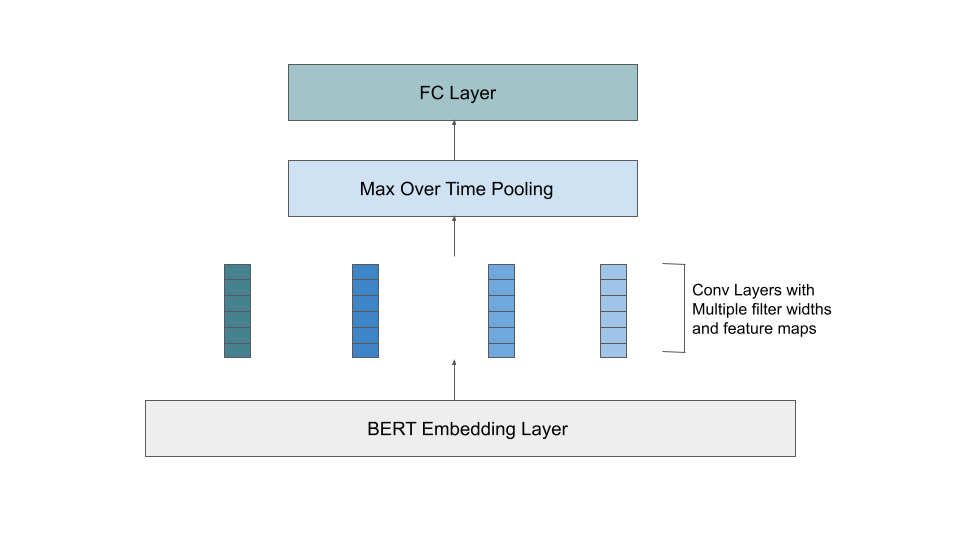

he above diagram provides a visual representation of the architecture. The intution behind each part of the architecture is as follows:

*   **Pre Trained BERT**: BERT was used to get high quality word embeddings which are extremely critical to achieve high performance.
*   **KimCNN**: The conv layers with different feature widths help the network look at different features of the tensor, leading to significant increase in the performance.


In [ ]:
class KimCNN(nn.Module):
  def __init__(self,preTrainedBert,inChannels=1,embeddingDimension=768,numClasses=27):
    super(KimCNN,self).__init__()

    self.inChannels=inChannels
    self.embDim=embeddingDimension
    self.numClasses=numClasses

    self.bert=self.freezeBert(preTrainedBert)
    
    self.kimConv0=nn.Conv2d(in_channels=self.inChannels,out_channels=100,kernel_size=(2,self.embDim))
    self.kimConv1=nn.Conv2d(in_channels=self.inChannels,out_channels=100,kernel_size=(3,self.embDim))
    self.kimConv2=nn.Conv2d(in_channels=self.inChannels,out_channels=100,kernel_size=(4,self.embDim))
    self.kimConv3=nn.Conv2d(in_channels=self.inChannels,out_channels=100,kernel_size=(5,self.embDim))
    self.dropoutLayer=nn.Dropout(p=0.5)
    self.fc=nn.Linear(400,self.numClasses)

  def forward(self,input):

    bertOutput=self.bert(input_ids=input['input_ids'].squeeze(dim=1),attention_mask=input['attention_mask'].squeeze(dim=1),token_type_ids=input['token_type_ids'].squeeze(dim=1)).last_hidden_state
    
    kimInput=bertOutput.unsqueeze(1)
    
    conv0_Output=F.relu(self.kimConv0(kimInput)).squeeze(3)
    conv1_Output=F.relu(self.kimConv1(kimInput)).squeeze(3)
    conv2_Output=F.relu(self.kimConv2(kimInput)).squeeze(3)
    conv3_Output=F.relu(self.kimConv3(kimInput)).squeeze(3)
    
    conv0_Output=F.max_pool1d(conv0_Output,conv0_Output.size(2))
    conv1_Output=F.max_pool1d(conv1_Output,conv1_Output.size(2))
    conv2_Output=F.max_pool1d(conv2_Output,conv2_Output.size(2))
    conv3_Output=F.max_pool1d(conv3_Output,conv3_Output.size(2))

    kimOutput=torch.cat((conv0_Output.squeeze(dim=2),conv1_Output.squeeze(dim=2),conv2_Output.squeeze(dim=2),conv3_Output.squeeze(dim=2)),dim=1)

    output=self.fc(self.dropoutLayer(kimOutput))

    return output

  def freezeBert(self,model):
    for params in model.parameters():
      params.requires_grad=False
    return model


Adam was used as an optimizer with a learning rate of 10^-4 and Cross Entropy Loss was used as the loss function.

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
kimcnn=KimCNN(preTrainedBert=model)
kimcnn.to(device)
softmaxLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(kimcnn.parameters(), lr=0.0001)

In [ ]:
def Average(lst): 
    return sum(lst) / len(lst) 

def train_model(model,epochs):

  trainBatchCount=0
  testBatchCount=0

  avgTrainAcc=[]
  avgValidAcc=[]
  trainAcc=[]
  validAcc=[]
  trainLosses=[]
  validLosses=[]
  avgTrainLoss=[]
  avgValidLoss=[]


  for i in range(epochs):

    print("Epoch:",i)

    model.train()
    print("Training.....")
    for batch_idx,(data,targets) in enumerate(trainLoader):

      trainBatchCount=trainBatchCount+1

      targets=targets.to(device)

      optimizer.zero_grad()

      scores=model(data)
       
      loss=softmaxLoss(scores,targets)

      loss.backward()

      optimizer.step()

      trainLosses.append(float(loss))

      
      correct=0
      total=0
      total=len(targets)


      predictions=torch.argmax(scores,dim=1)
      correct = (predictions==targets).sum()
      acc=float((correct/float(total))*100)

      trainAcc.append(acc)

      if ((trainBatchCount%200)==0):

        print("Targets:-",targets)
        print("Predictions:-",predictions)

        print('Loss: {}  Accuracy: {} %'.format(loss.data, acc))

    model.eval()
    print("Validating.....")
    for data,targets in valLoader:

      testBatchCount=testBatchCount+1

      targets=targets.to(device=device)

      scores=model(data)

      loss=softmaxLoss(scores,targets)

      validLosses.append(float(loss))

      testCorrect=0
      testTotal=0

      _,predictions=scores.max(1)

      testCorrect = (predictions==targets).sum()
      testTotal=predictions.size(0)

      testAcc=float((testCorrect/float(testTotal))*100)

      validAcc.append(testAcc)

      if ((testBatchCount%200)==0):

        print('Loss: {}  Accuracy: {} %'.format(float(loss), testAcc))
    

    trainLoss=Average(trainLosses)
    validLoss=Average(validLosses)
    avgTrainLoss.append(trainLoss)
    avgValidLoss.append(validLoss)
    tempTrainAcc=Average(trainAcc)
    tempTestAcc=Average(validAcc)
    avgTrainAcc.append(tempTrainAcc)
    avgValidAcc.append(tempTestAcc)

    print("Epoch Number:-",i,"  ","Training Loss:-"," ",trainLoss,"Validation Loss:-"," ",validLoss,"Training Acc:-"," ",tempTrainAcc,"Validation Acc:-"," ",tempTestAcc)

    trainAcc=[]
    ValidAcc=[]
    trainLosses=[]
    validLosses=[]

  return model,avgTrainLoss,avgValidLoss,avgTrainAcc,avgValidAcc


The model was trained for 10 epochs

In [ ]:
kimcnn,avgTrainLoss,avgValidLoss,avgTrainAcc,avgValidAcc=train_model(kimcnn,10)

Epoch: 0
Training.....
Targets:- tensor([ 8, 12, 14, 25, 20,  9,  3, 20], device='cuda:0')
Predictions:- tensor([ 8,  8, 25, 25, 12,  9,  3, 20], device='cuda:0')
Loss: 2.2079665660858154  Accuracy: 62.5 %
Targets:- tensor([19, 21,  8, 24,  9, 10, 14,  9], device='cuda:0')
Predictions:- tensor([20, 13,  8, 12, 11, 10, 16,  9], device='cuda:0')
Loss: 2.011904239654541  Accuracy: 37.5 %
Targets:- tensor([ 2,  4,  7, 17, 20,  9, 14, 26], device='cuda:0')
Predictions:- tensor([ 2,  4,  7, 17, 20,  9, 14, 26], device='cuda:0')
Loss: 1.2164746522903442  Accuracy: 100.0 %
Targets:- tensor([25, 16,  6, 17,  0, 13, 21, 20], device='cuda:0')
Predictions:- tensor([18, 16, 11, 17,  0, 13, 21, 20], device='cuda:0')
Loss: 1.265690803527832  Accuracy: 75.0 %
Targets:- tensor([11, 19, 15,  3, 12,  3,  5,  5], device='cuda:0')
Predictions:- tensor([11, 19, 15,  3,  8,  3,  5,  5], device='cuda:0')
Loss: 1.3759269714355469  Accuracy: 87.5 %
Targets:- tensor([17, 22, 11,  8,  5, 16, 16,  4], device='cuda

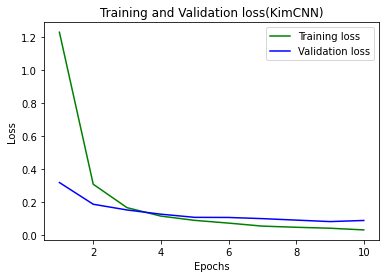

In [ ]:
#Loss Behaviour against Epochs
loss_train = avgTrainLoss
loss_val = avgValidLoss
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss(KimCNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

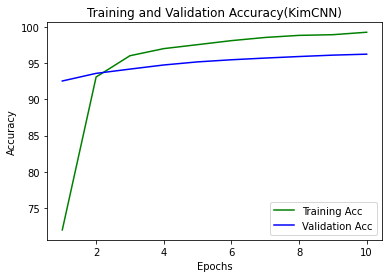

In [ ]:
#Accuracy Behaviour against Epochs
acc_train = avgTrainAcc
acc_val = avgValidAcc
epochs = range(1,11)
plt.plot(epochs, acc_train, 'g', label='Training Acc')
plt.plot(epochs, acc_val, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy(KimCNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def checkClassificationMetrics(loader,model):

  completeTargets=[]
  completePreds=[]

  correct=0
  total=0
  model.eval()

  with torch.no_grad():
    for data,targets in loader:

      targets=targets.to(device=device)

      scores=model(data)
      _,predictions=scores.max(1)

      targets=targets.tolist()
      predictions=predictions.tolist()

      completeTargets.append(targets)
      completePreds.append(predictions)

    completeTargetsFlattened=[item for sublist in completeTargets for item in sublist]
    completePredsFlattened=[item for sublist in completePreds for item in sublist]

    cm = ConfusionMatrix(actual_vector=completeTargetsFlattened, predict_vector=completePredsFlattened)
    return cm

In [ ]:
CM=checkClassificationMetrics(testLoader,kimcnn)

A number of evaluation metrics were considered. The pycm module was utilized to calculate these metrics

In [ ]:
print("Evaluation Metrics:-")
print("Accuracy:-", CM.Overall_ACC*100)
print("F1 Micro:-", CM.F1_Micro)
print("Kappa:-",CM.Kappa)
print("MCC:-",CM.Overall_MCC)

Evaluation Metrics:-
Accuracy:- 97.91454730417091
F1 Micro:- 0.9791454730417091
Kappa:- 0.9754769022392242
MCC:- 0.9754986616887074


In [ ]:
torch.save(kimcnn.state_dict(),"path_to_add/MIDAS_Task3/Models/KimCNN.pt") #Please add path_to_add that is required for your local Machine